<a href="https://colab.research.google.com/github/stirlitzzz/OECD_demo/blob/main/OECD_demo_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Intro

Figuring out market regimes seems to be a big area in asset allocation that has some papers that make sense.

Here is a very simple one:  https://grzegorz.link/growth

They classify regimes base on the value of the diffusion index of the composite leading indicators (CLI) for different OECD countries and a few other countries

See the paper or run the cells down to the **Plot the average CLI and diffusion index** section to see what the CLI and diffusion indeces look like.

Quick explanation

- CLI: (composite leading indicators) a weighted index of leading indicators.

- Diffusion index of Month over Month CLI changes: **Diffusion index** seems to be a nice concept in that it is basically just a percentage of indicators that are up, so there is no weighting involved.  In this case its percentage of countries whose CLI's are up month over months

A promising feature of the diffusion index is the following: the times when the diffusion index crosses above or below 50% pretty consistently corresponds to maximum or minumum of the **CLI** 
- See graphs 1,2 in the **Average CLI across countries and diffusion index Graphs** section






When it comes to using this on SPX prices: obviously less clean, but if you are long SPX when the diffusion index >=.5 and out of the market otherwise, your annual return is only 1% less (7.8 vs 8.5) but the max drawdown is a lot smaller(17% vs 56%) <-- see graph 4 in **Graph the SPX backtest performance** section.

If you change the backtest to accrue interest on the unused cash when you are out of the market, it outperforms SPX

The paper instead uses some kind of moving average market strategy when its out of the market to outperform 

**Consequences**
- this particular result  seems to be common knowledge for the big hedge funds which probably means they use it to determine their allocations
- using market regimes is potentially useful for any strategy, you could be doing something different depending on the market regime
- There are a number of decent papers on market regimes, this is just the simplest one.

## Set up

In [ ]:
#%matplotlib %cda inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from pandas.io.stata import relativedelta

## Utility Functions

In [ ]:
def convert_oecd_str_to_date(names):
    result=[datetime.datetime.strptime(x, '%Y-%m')+relativedelta(months=1) for x in names]
    return result

In [ ]:
def generate_strategy(date_index,s,signal_buy, signal_sell, interest_rates, init_cash,init_shares, use_interest=True):
    shares=np.zeros_like(s)
    cash=np.zeros_like(s)
    shares[0]=init_shares
    cash[0]=init_cash
    for i in range(1, s.count()):
        dc=(date_index[i]-date_index[i-1]).days
        cash_on_open=cash[i-1]*(1+interest_rates[i-1]*dc/360*use_interest)
        shares[i]=(1-signal_sell[i])*shares[i-1]+signal_buy[i]*cash_on_open/s[i]
        cash[i]=(1-signal_buy[i])*cash_on_open+signal_sell[i]*s[i]*shares[i-1]
    return (cash, shares,cash+shares*s)

In [ ]:
def find_dd_max(s):
    s_max=s[0]
    dd_max=0
    for i in range(1,len(s)):
        s_max=max(s_max,s[i])
        dd=-(s[i]/s_max-1)
        dd_max=max(dd_max,dd)
    return dd_max



## Load and Process Data

In [ ]:
oecd_raw_data=pd.read_csv('https://raw.githubusercontent.com/stirlitzzz/OECD_demo/main/OECD_indicators_raw.csv')
spx_price_data=pd.read_csv('https://raw.githubusercontent.com/stirlitzzz/OECD_demo/main/SPX_1980_historical_data.csv',index_col="Date")
df_interest_rates=pd.read_csv('https://raw.githubusercontent.com/stirlitzzz/OECD_demo/main/Interest_Rates_clean.csv',index_col="Date")


Process the data

In [ ]:
#convert columns to the right type
spx_price_data.index=pd.to_datetime(spx_price_data.index)
df_interest_rates.index=pd.to_datetime(df_interest_rates.index)
spx_price_data.Close=pd.to_numeric(spx_price_data.Close)

#first step is to set up the pivot table
oecd_pivot=pd.pivot_table(oecd_raw_data,values='Value',index='TIME', columns='LOCATION', aggfunc=np.mean)
#find the average value for each time slice
oecd_index=oecd_pivot.mean(axis=1)/100


#Compute the diffusion index (percent of location with CLI index up month over month)
oecd_monthly_diffs=oecd_pivot.diff(axis=0)
a=oecd_monthly_diffs>0
b=oecd_monthly_diffs<=0
oecd_monthly_diffusion_index=a.sum(axis=1)/(a.sum(axis=1)+b.sum(axis=1))

#compute the buy and sell signals: buy when diffusion index is > threshold, sell when <=threshold
threshold=.5
aa=(oecd_monthly_diffusion_index.shift(periods=1)>.5)
bb=oecd_monthly_diffusion_index<=.5
cc=aa&bb

dd=np.asarray((oecd_monthly_diffusion_index.shift(periods=1)>=threshold)&(oecd_monthly_diffusion_index<threshold))
ee=np.asarray((oecd_monthly_diffusion_index.shift(periods=1)<threshold)&(oecd_monthly_diffusion_index>=threshold))
oecd_index_cross_down=oecd_index[dd]
oecd_index_cross_up=oecd_index[ee]

Preprocess the diffusion index so it can be combined with SPX. The index for each month is published by OECD on the 15th of the next months.
1) Add on emonth and 15 days to all of the diffusion index dates
2) Resample to the index to be daily on all business days

In [ ]:
#make a copy of the original series, change the index to datetime, and move forward by 15 days
oecd_diffusion_series=oecd_monthly_diffusion_index.copy()
oecd_diffusion_dates=[datetime.datetime.strptime(x, '%Y-%m')+relativedelta(months=1)+relativedelta(days=14) for x in oecd_monthly_diffusion_index.index]
oecd_diffusion_series.index=oecd_diffusion_dates
oecd_upsampled_diffusion=oecd_diffusion_series.resample('B').ffill()

Merge the daily diffusion index with the SPX prices

In [ ]:
df_oecd_daily=pd.DataFrame(oecd_upsampled_diffusion)
df_oecd_daily.columns=["oecd_diffusion"]
df_oecd_daily.index.name="Date"
spx_oecd_daily=spx_price_data.merge(df_oecd_daily,left_index=True,right_index=True)
spx_oecd_daily=spx_oecd_daily.merge(df_interest_rates,left_index=True,right_index=True )
spx_oecd_daily["oecd_diffusion_lag"]=spx_oecd_daily["oecd_diffusion"].shift(periods=1)

## Average CLI across countries and diffusion index Graphs

---



Text(0.5, 1.0, 'Graph 2. Average CLI index with buy/sell signals when the diffusion index crosses 50%')

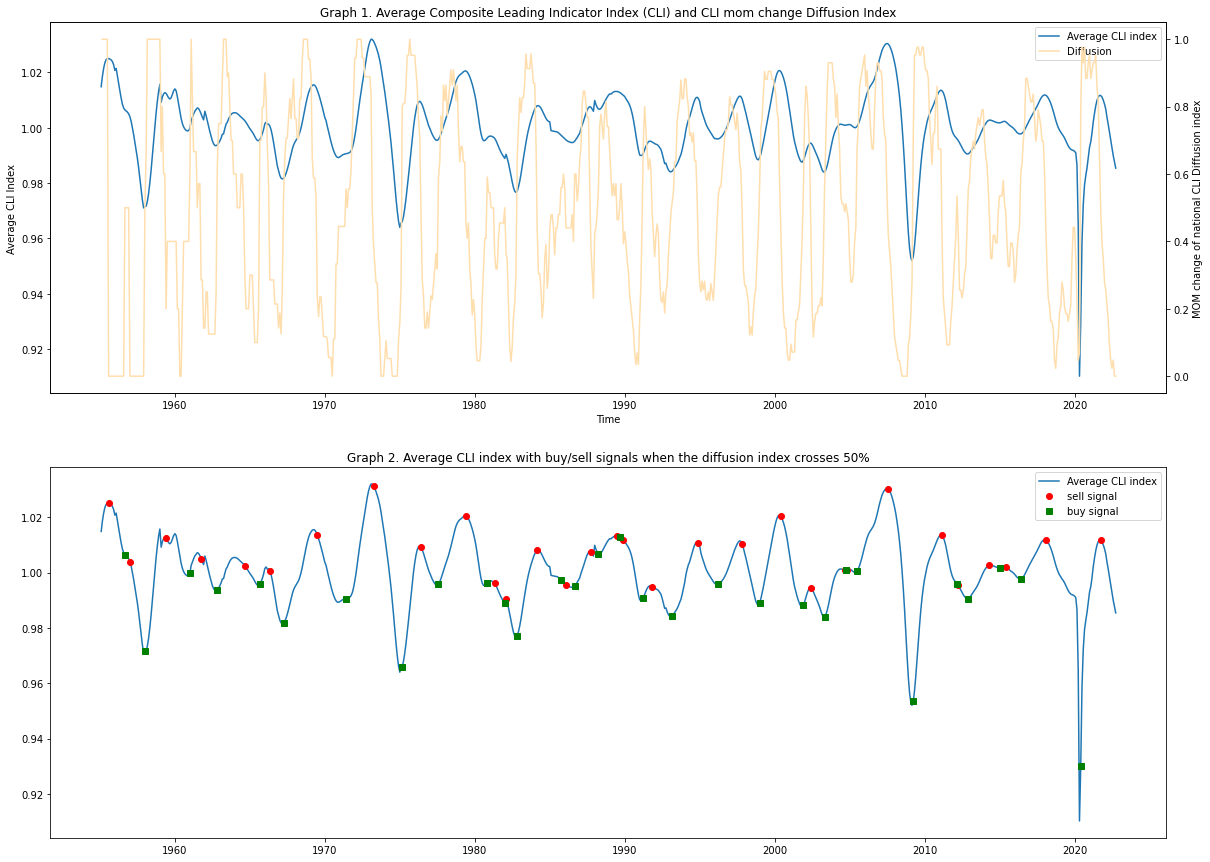

In [ ]:
fix,axes = plt.subplots(2,figsize=(20, 15))
ax=axes[0]
ax2=ax.twinx()

#create the series
lns1=ax.plot(convert_oecd_str_to_date(oecd_index.index),oecd_index,label="Average CLI index")
lns2=ax2.plot(convert_oecd_str_to_date(oecd_monthly_diffusion_index.index),oecd_monthly_diffusion_index, color="navajowhite", label="Diffusion")

# create the legend
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=1)

ax.set_title('Graph 1. Average Composite Leading Indicator Index (CLI) and CLI mom change Diffusion Index')
ax.set_xlabel("Time")
ax.set_ylabel('Average CLI Index')
ax2.set_ylabel('MOM change of national CLI Diffusion index')

ax=axes[1]
ax.plot(convert_oecd_str_to_date(oecd_index.index),oecd_index,label="Average CLI index")
ax.plot(convert_oecd_str_to_date(oecd_index_cross_down.index),oecd_index_cross_down,color='red', marker='o', linewidth=0, label="sell signal")
ax.plot(convert_oecd_str_to_date(oecd_index_cross_up.index),oecd_index_cross_up,color='green', marker='s', linewidth=0, label="buy signal")
ax.legend(loc="upper right")
ax.set_title('Graph 2. Average CLI index with buy/sell signals when the diffusion index crosses 50%')

## CLI diffusion index buy sell signals vs SPX

Compute the buy and sell signal for the resampled and combined dataset

In [ ]:
threshold=.5
#buy and sell signals in their own datafrane
df_sell_signal=spx_oecd_daily[(spx_oecd_daily['oecd_diffusion'] <threshold)& (spx_oecd_daily['oecd_diffusion_lag'] >=threshold)]
df_buy_signal=spx_oecd_daily[(spx_oecd_daily['oecd_diffusion'] >=threshold)& (spx_oecd_daily['oecd_diffusion_lag']< threshold)]

#put buy and sell signals into the SPX price/interest rate/Diffusion index dataframe

spx_oecd_daily["sell_signal"]=(spx_oecd_daily['oecd_diffusion'] <threshold)& (spx_oecd_daily['oecd_diffusion_lag'] >=threshold)
spx_oecd_daily["buy_signal"]=(spx_oecd_daily['oecd_diffusion'] >=threshold)& (spx_oecd_daily['oecd_diffusion_lag']< threshold)


Run the backtest.
The paper does not deploy cash when its not used to buy SPX. 
Set b_use_interest=False to not accrue interest (match the paper)
set b_use_interest=True to accrue interest overnight



In [ ]:
b_use_interest=False # <==set this to false to do without interest, true with interest

#create the imput dataframe
df_inputs=spx_oecd_daily[["buy_signal","sell_signal","Close","InterestRate"]].copy()
df_inputs["cash"]=np.zeros_like(df_inputs.Close)
df_inputs["shares"]=np.zeros_like(df_inputs.Close)
df_inputs["value"]=np.zeros_like(df_inputs.Close)

(long_cash,long_shares,long_value)=generate_strategy(df_inputs.index,df_inputs.Close,df_inputs.buy_signal,df_inputs.sell_signal,df_inputs.InterestRate/100,0,1,use_interest=b_use_interest)
(short_cash,short_shares,short_value)=generate_strategy(df_inputs.index,df_inputs.Close,df_inputs.sell_signal,df_inputs.buy_signal,df_inputs.InterestRate/100,0,1,use_interest=b_use_interest)

#find max drawdown
dd_long=find_dd_max(long_value)
dd_bh=find_dd_max(df_inputs.Close)
dd_short=find_dd_max(short_value)
#find cagr (compound annual growth rate)
t_backtest=(df_inputs.index[-1]-df_inputs.index[0]).days/365.25
cagr_bh=np.power(df_inputs.Close[-1]/df_inputs.Close[0],1/t_backtest)-1
cagr_long=np.power(long_value[-1]/long_value[0],1/t_backtest)-1
cagr_short=np.power(short_value[-1]/short_value[0],1/t_backtest)-1

## Graph the SPX backtest performance

Text(0.5, 1.0, 'Graph 4. Backtest')

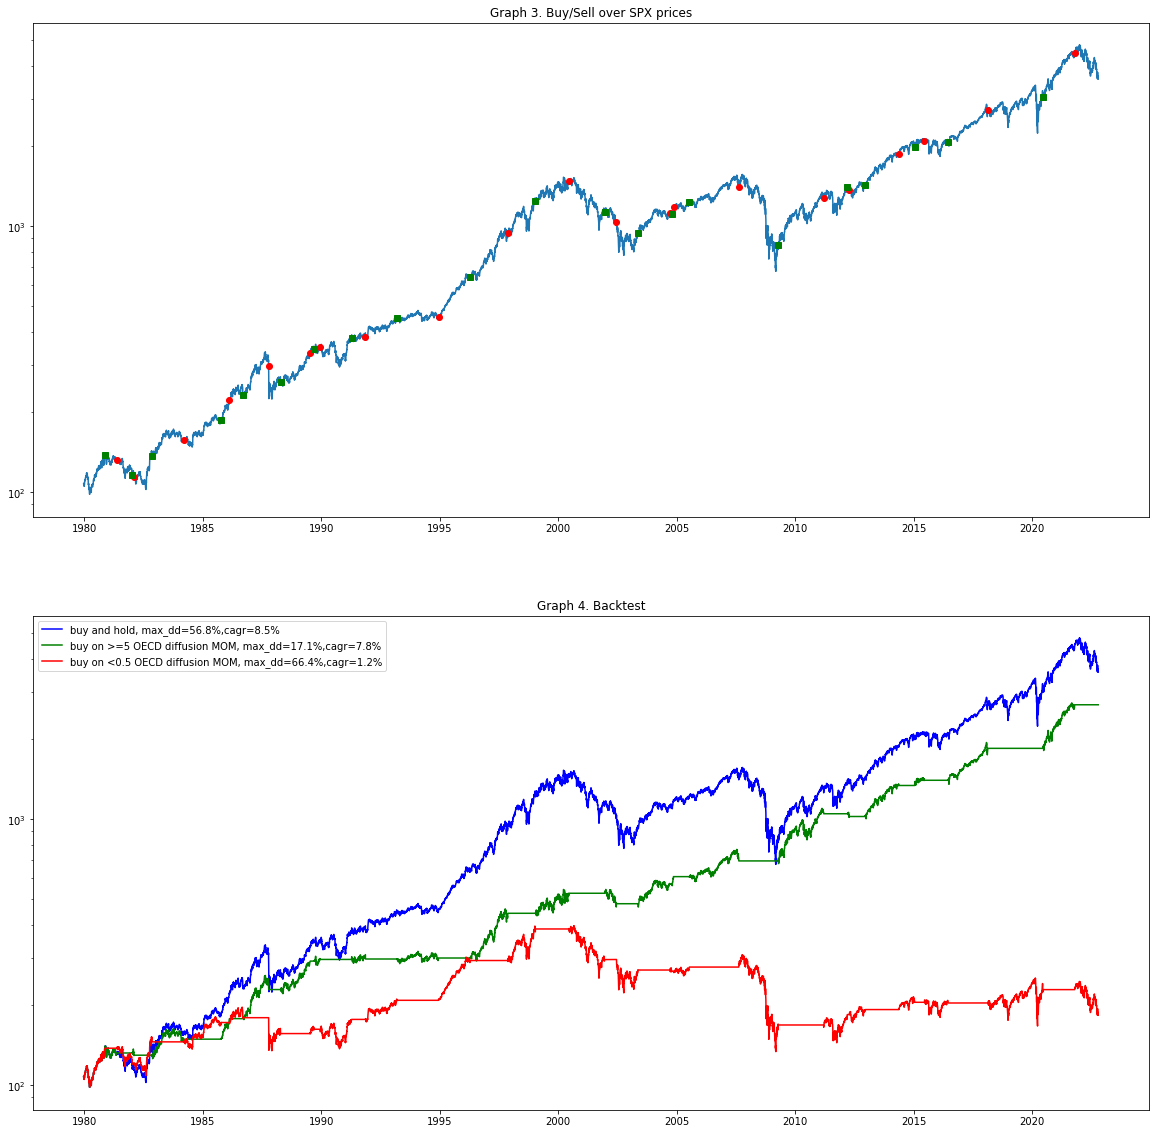

In [ ]:
fig,axes = plt.subplots(2,figsize=(20, 20))
ax=axes[0]
ax.plot(spx_oecd_daily.index,spx_oecd_daily.Close)
ax.plot(df_sell_signal.index,df_sell_signal.Close,color='red', marker='o', linewidth=0)
ax.plot(df_buy_signal.index,df_buy_signal.Close,color='green', marker='s', linewidth=0)
ax.set_yscale('log')
ax.set_title('Graph 3. Buy/Sell over SPX prices')

ax=axes[1]
ax.plot(df_inputs.index,df_inputs.Close,label="buy and hold, max_dd={:.1%},cagr={:.1%}".format(dd_bh,cagr_bh),color='blue')
ax.plot(df_inputs.index,long_value,label="buy on >=5 OECD diffusion MOM, max_dd={:.1%},cagr={:.1%}".format(dd_long,cagr_long),color='green')
ax.plot(df_inputs.index,short_value,label="buy on <0.5 OECD diffusion MOM, max_dd={:.1%},cagr={:.1%}".format(dd_short,cagr_short),color='red')
ax.legend(loc="upper left")
ax.set_yscale('log')
ax.set_title('Graph 4. Backtest')


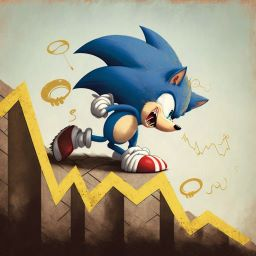

## Half Baked code

Graph the performance before and after the signal

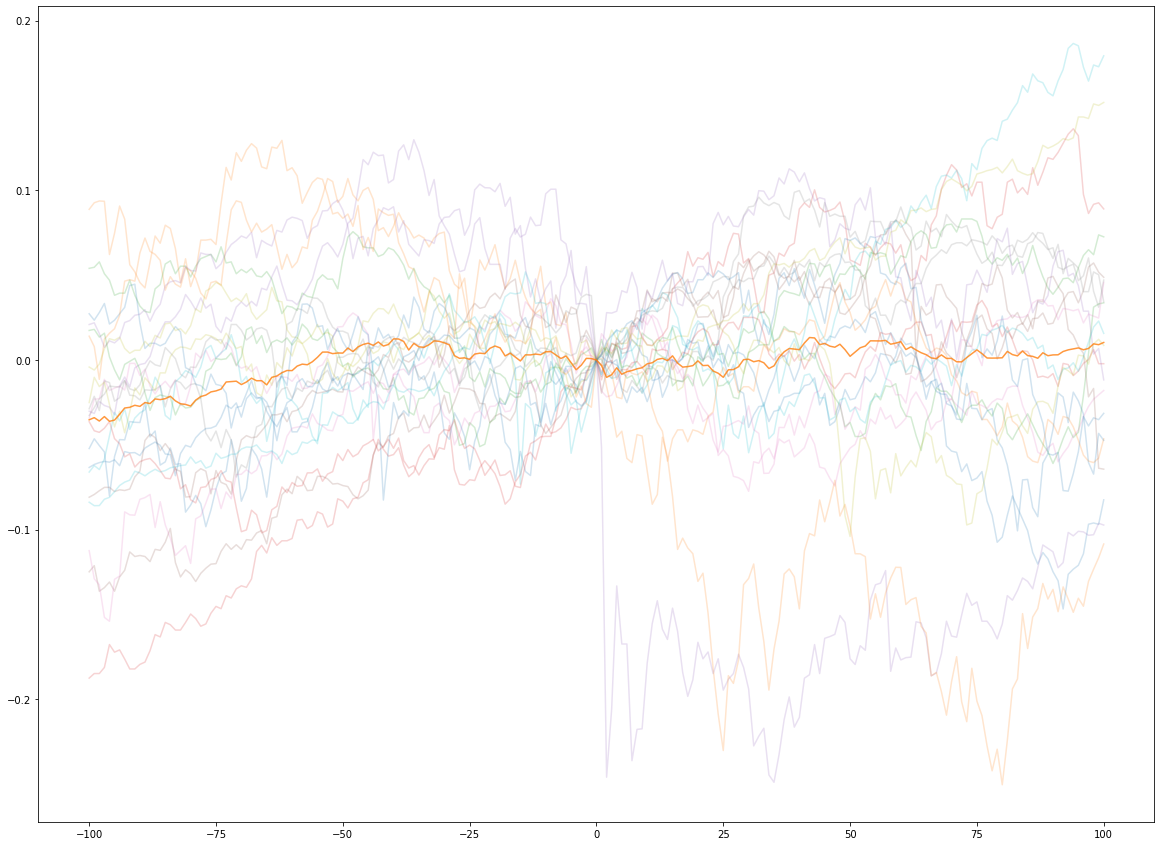

In [ ]:
sell_date_locs=[spx_oecd_daily.Close.iloc[spx_oecd_daily.index.get_loc(x)+ np.array(range(-100,101))] for x in df_sell_signal.index]
sell_date_center_locs=[spx_oecd_daily.Close.iloc[spx_oecd_daily.index.get_loc(x)] for x in df_sell_signal.index]
spx_oecd_daily.Close.iloc[sell_date_center_locs]

b=[np.array(x/y -1)for (x,y) in zip(sell_date_locs,sell_date_center_locs)]

fix,ax = plt.subplots(figsize=(20, 15))
for i in range(len(b)):
    ax.plot(range(-100,101),b[i], alpha=.2)
c = np.vstack( b )
ax.plot(range(-100,101),np.mean(c,axis=0), alpha=.8)


Code for weekly resampling to a particular weekday. Don't need it here, but keeping because I looked it up already

In [ ]:
#code to resample data to weekly by a particular day of the week
#oecd_weekly_diffusion=oecd_upsampled_diffusion
#spx_weekly_prices=spx_price_data
#oecd_weekly_diffusion=oecd_upsampled_diffusion.resample('W-Mon').ffill()
#spx_weekly_prices=spx_price_data.resample('W-Mon').ffill()
#oecd_weekly_diffusion[spx_weekly_prices.index[:-3]]
#fix,ax = plt.subplots(figsize=(20, 15))